**<h1>TC3007C Inteligencia Artificial Avanzada para la Ciencia de Datos</h1>**
<h2>Maximiliano De La Cruz Lima — A01798048</h2>
<h3>Dr. Julio Guillermo Arriaga Blumenkron — M2. Técnicas y arquitecturas de deep learning</h3>

# Introducción

En el presente portafolio se documenta el desarrollo de modelos de deep learning, especificamente de redes neuronales convolucionales (CNNs), para la clasificación de imágenes médicas de rayos X del torax de pacientes que presentan alguno de los siguientes padecimientos:

* COVID-19
* Neumonía
* Opacidad pulmonar
* Ninguno (sano)

Esto es particularmente relevante en el contexto médico actual, especialmente en el ámbito del diagnóstico de enfermedades respiratorias o cerebrales mediante la interpretación de imágenes médicas. La capacidad de clasificar correctamente estas imágenes tiene un impacto importante en la detección temprana y precisa de enfermedades, lo que a su vez puede mejorar significativamente los resultados del tratamiento y la atención al paciente (Kermany et al., 2018).

Por lo tanto, el desarrollo de modelos de deep learning para la clasificación de imágenes médicas es un área de investigación con gran relevancia y potencial para mejorar el acceso a diagnósticos precisos y oportunos, que de otra forma podrían resultar costosos o inaccesibles para ciertos pacientes por la falta de especialistas médicos.

El dataset utilizado para este portafolio fue obtenido de Kaggle (https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database). 

El objetivo principal de este portafolio es construir y evaluar diferentes arquitecturas de CNNs para la clasificación de imágenes médicas, con el fin de identificar la arquitectura que mejor se desempeña en esta tarea específica.

# Carga de datos y preprocesamiento

El dataset utilizado, en su última iteración, está distribuido de la siguiente manera:
* Normal / Sano: 10192 imágenes
* COVID-19: 3616 imágenes
* Neumonía: 6012 imágenes
* Opacidad pulmonar: 1345 imágenes

In [14]:
!chmod 600 ./kaggle.json
!kaggle --version

Kaggle API 1.7.4.5


In [15]:
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database
License(s): copyright-authors
 88%|███████████████████████████████████▎    | 688M/778M [00:00<00:00, 1.79GB/s]
100%|████████████████████████████████████████| 778M/778M [00:00<00:00, 1.80GB/s]


In [16]:
!unzip -qq covid19-radiography-database.zip

## Visualización de las imágenes

Para tener una mejor idea del dataset, a continuación se muestran algunas imágenes de cada clase:

Buscando en: COVID-19_Radiography_Dataset/COVID/images/


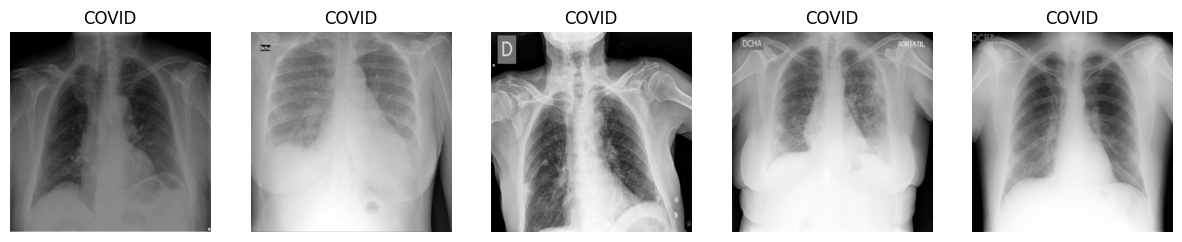

Buscando en: COVID-19_Radiography_Dataset/Normal/images/


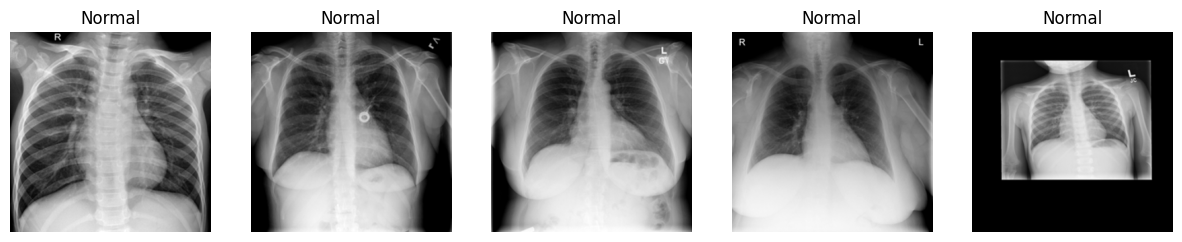

Buscando en: COVID-19_Radiography_Dataset/Viral Pneumonia/images/


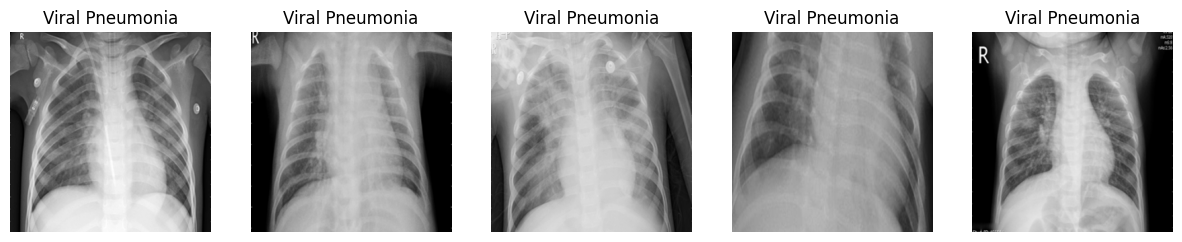

Buscando en: COVID-19_Radiography_Dataset/Lung_Opacity/images/


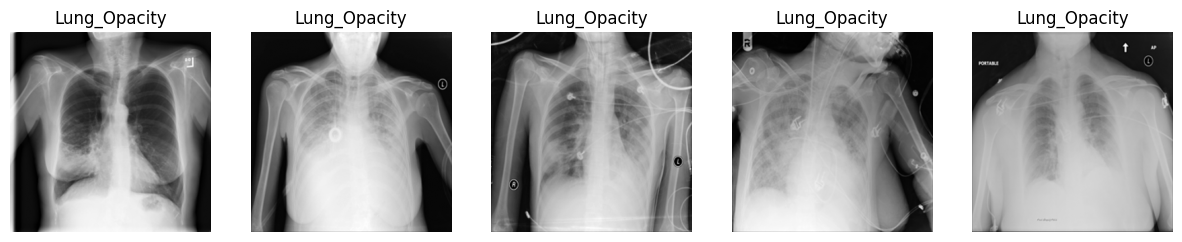

In [101]:
import os
import pandas as pd
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt


base = Path("COVID-19_Radiography_Dataset")


def mostrar_imagenes_de_clase(clase, num_imagenes=5):
    ruta_clase = os.path.join(base, clase, "images/")
    print("Buscando en:", ruta_clase)

    imagenes = os.listdir(ruta_clase)[:num_imagenes]

    plt.figure(figsize=(15, 5))
    for i, img_name in enumerate(imagenes):
        img_path = os.path.join(ruta_clase, img_name)
        img = Image.open(img_path)
        plt.subplot(1, num_imagenes, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"{clase}")
        plt.axis('off')
    plt.show()

clases = ['COVID', 'Normal', 'Viral Pneumonia', 'Lung_Opacity']
for clase in clases:
    mostrar_imagenes_de_clase(clase)


## División de los datos

Ahora, se procede a dividir el dataset en conjuntos de entrenamiento, validación y prueba. Se utiliza un 80% de los datos para entrenamiento, un 10% para validación y un 10% para prueba.

In [102]:
# Crear un DataFrame con las rutas de las imágenes y sus etiquetas
rows = []
for c in clases:
    image_dir = base / c / "images"
    for img_path in image_dir.glob("*.png"):
        rows.append({"image_path": str(img_path), "label": c})

df = pd.DataFrame(rows)
print("Distribución original de clases:", df['label'].value_counts().to_dict())

# Dividir el DataFrame en conjuntos de entrenamiento, validación y prueba
from sklearn.model_selection import train_test_split
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)
print("Distribución de clases en entrenamiento:", train_df['label'].value_counts().to_dict())
print("Distribución de clases en validación:", val_df['label'].value_counts().to_dict())
print("Distribución de clases en prueba:", test_df['label'].value_counts().to_dict())

Distribución original de clases: {'Normal': 10192, 'Lung_Opacity': 6012, 'COVID': 3616, 'Viral Pneumonia': 1345}
Distribución de clases en entrenamiento: {'Normal': 8154, 'Lung_Opacity': 4809, 'COVID': 2893, 'Viral Pneumonia': 1076}
Distribución de clases en validación: {'Normal': 1019, 'Lung_Opacity': 601, 'COVID': 361, 'Viral Pneumonia': 135}
Distribución de clases en prueba: {'Normal': 1019, 'Lung_Opacity': 602, 'COVID': 362, 'Viral Pneumonia': 134}


Posteriormente, se aplican técnicas de aumento de datos (data augmentation) para mejorar la generalización del modelo y reducir el sobreajuste (overfitting). Estas técnicas incluyen rotaciones aleatorias, desplazamientos horizontales y verticales, zoom y volteo horizontal.

Asimismo, se calcula el peso de cada clase para manejar el desbalanceo en el dataset. Estos pesos se utilizarán durante el entrenamiento del modelo para dar mayor importancia a las clases minoritarias.

In [103]:
import tensorflow as tf

IMG_SIZE = 224
BATCH = 32
AUTOTUNE = tf.data.AUTOTUNE

# Funciones para cargar y preprocesar las imágenes
def decode_img(img_path, label):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    return img, label

# Función de aumento de datos
def augment(img, label):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, 0.05)
    img = tf.image.random_contrast(img, 0.9, 1.1)
    return img, label

# Crear datasets de TensorFlow
label2idx = {c:i for i,c in enumerate(clases)}

def df_to_dataset(df, shuffle=True, augment_data=False, cache=False):
    paths  = df['image_path'].values
    labels = df['label'].map(label2idx).values
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))

    if shuffle:
        ds = ds.shuffle(buffer_size=min(len(df), 1000))

    ds = ds.map(decode_img, num_parallel_calls=AUTOTUNE)

    if augment_data:
        ds = ds.map(augment, num_parallel_calls=AUTOTUNE)

    if cache is True:
        ds = ds.cache()
    elif isinstance(cache, str):
        ds = ds.cache(cache)

    ds = ds.batch(BATCH).prefetch(AUTOTUNE)
    return ds

train_ds = df_to_dataset(train_df, shuffle=True,  augment_data=True,  cache=False)
val_ds   = df_to_dataset(val_df,   shuffle=False, augment_data=False, cache=False)
test_ds  = df_to_dataset(test_df,  shuffle=False, augment_data=False, cache=False)

counts = train_df["label"].value_counts().reindex(clases).fillna(0).to_dict()
total = sum(counts.values())
class_weights = {i: total/(len(clases)*counts[c]) for c,i in label2idx.items()}
class_weights


{0: 1.4631870031109575,
 1: 0.5191317144959529,
 2: 3.934014869888476,
 3: 0.8802245789145352}

In [104]:
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss over Epochs')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy over Epochs')

    plt.show()

# Modelado y entrenamiento

## Primer modelo: CNN simple desde cero

En primera instancia, se entrenó un modelo CNN simple desde cero, utilizando 3 capas de convolución seguidas de capas de pooling y capas densas al final. Este modelo sirvió como línea base para comparar el rendimiento de modelos más complejos.

In [105]:
from tensorflow import keras
from keras import layers, models, regularizers

model1 = models.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.Rescaling(1./255),


    layers.Conv2D(32, (3, 3), padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),

    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(clases), activation='softmax')
])

model1.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_10 (Rescaling)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 224, 224, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_36 (Activation)      │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_45 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 112, 112, 64)   │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_37 (Activation)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_46 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 56, 56, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_38 (Activation)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_47 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,948 (433.39 KB)

 Trainable params: 110,500 (431.64 KB)

 Non-trainable params: 448 (1.75 KB)

Se utiliza la función de pérdida de entropía cruzada categórica, el optimizador Adam y se monitorea la métrica de precisión durante el entrenamiento. Además, se implementan técnicas de regularización como early stopping y reducción de la tasa de aprendizaje para evitar el sobreajuste y mejorar la convergencia del modelo.

In [106]:
model1.compile(optimizer='adam',
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
]

In [107]:
history1 = model1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/50


530/530 ━━━━━━━━━━━━━━━━━━━━ 31s 51ms/step - accuracy: 0.6079 - loss: 0.8331 - val_accuracy: 0.3710 - val_loss: 1.8547 - learning_rate: 0.0010
Epoch 2/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 25s 47ms/step - accuracy: 0.7067 - loss: 0.6163 - val_accuracy: 0.6479 - val_loss: 0.9588 - learning_rate: 0.0010
Epoch 3/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 25s 47ms/step - accuracy: 0.7460 - loss: 0.5270 - val_accuracy: 0.2911 - val_loss: 3.3656 - learning_rate: 0.0010
Epoch 4/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 25s 47ms/step - accuracy: 0.7638 - loss: 0.4925 - val_accuracy: 0.7004 - val_loss: 0.8101 - learning_rate: 0.0010
Epoch 5/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 25s 47ms/step - accuracy: 0.7768 - loss: 0.4575 - val_accuracy: 0.7079 - val_loss: 0.7186 - learning_rate: 0.0010
Epoch 6/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 25s 47ms/step - accuracy: 0.7906 - loss: 0.4209 - val_accuracy: 0.2538 - val_loss: 3.9855 - learning_rate: 0.0010
Epoch 7/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 25s 47ms/step - accuracy: 0.8036 - loss: 0.3949

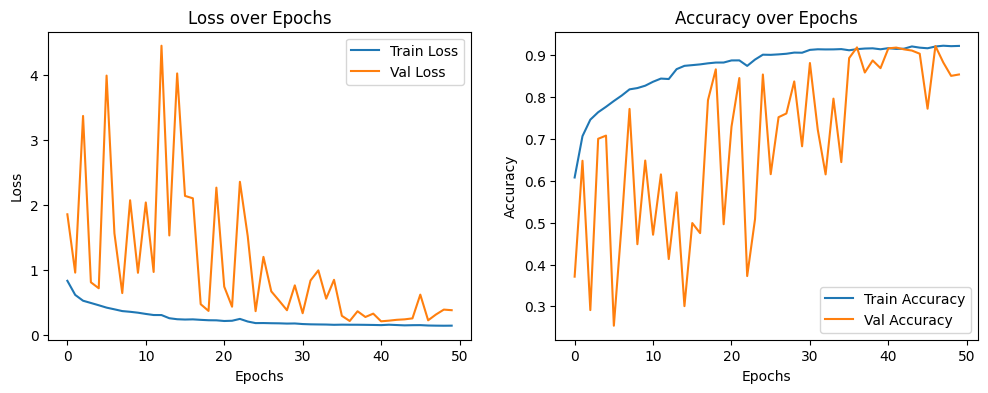

67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8994 - loss: 0.2614
Test Loss: 0.2614, Test Accuracy: 0.8994


In [108]:
plot_history(history1)
loss, accuracy = model1.evaluate(test_ds)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

Trás el entrenamiento del modelo simple, se puede observar un rendimiento, que si bien es aceptable, deja mucho que desear en comparación con modelos más avanzados, sobre todo por el caracter complejo de las imágenes médicas y la necesidad de capturar características más sofisticadas para una clasificación precisa.

## Segundo Modelo: CNN más profunda 

En esta segunda iteración, se diseñó una arquitectura de CNN más profunda, incorporando más capas de convolución y pooling, así como una capa densa intermedia con un mayor número de neuronas.

In [109]:
model2 = models.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.Rescaling(1./255),

    layers.Conv2D(32, (3, 3), padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(128, (3, 3), padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, (3, 3), padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(len(clases), activation='softmax')
])

model2.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_11 (Rescaling)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 224, 224, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_39 (Activation)      │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_48 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 112, 112, 64)   │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_44          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_40 (Activation)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_49 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 56, 56, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_45          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_41 (Activation)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_50 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 28, 28, 256)    │       294,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_46          │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_42 (Activation)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_51 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 256)            │    12,845,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,236,196 (50.49 MB)

 Trainable params: 13,235,236 (50.49 MB)

 Non-trainable params: 960 (3.75 KB)

In [110]:
model2.compile(optimizer='adam',
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

In [111]:
history2 = model2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 37s 62ms/step - accuracy: 0.6412 - loss: 1.7182 - val_accuracy: 0.7079 - val_loss: 0.6966 - learning_rate: 0.0010
Epoch 2/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 29s 55ms/step - accuracy: 0.7650 - loss: 0.4977 - val_accuracy: 0.7826 - val_loss: 0.5545 - learning_rate: 0.0010
Epoch 3/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 30s 56ms/step - accuracy: 0.8099 - loss: 0.3929 - val_accuracy: 0.7368 - val_loss: 0.6484 - learning_rate: 0.0010
Epoch 4/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 30s 56ms/step - accuracy: 0.8302 - loss: 0.3505 - val_accuracy: 0.7320 - val_loss: 0.7128 - learning_rate: 0.0010
Epoch 5/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 30s 56ms/step - accuracy: 0.8548 - loss: 0.2869 - val_accuracy: 0.5950 - val_loss: 0.9459 - learning_rate: 0.0010
Epoch 6/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 30s 56ms/step - accuracy: 0.8861 - loss: 0.2199 - val_accuracy: 0.8762 - val_loss: 0.3305 - learning_rate: 5.0000e-04
Epoch 7/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 30s 56ms/step - accuracy: 0.8892

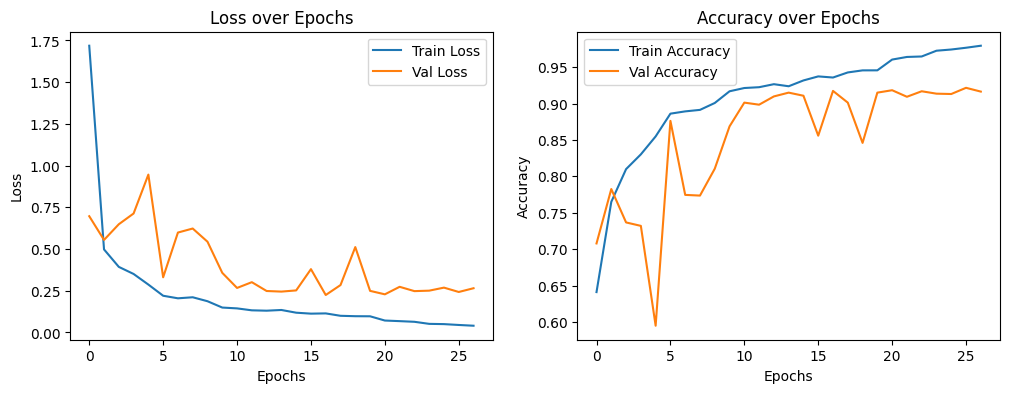

67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9098 - loss: 0.2767
Test Loss: 0.2767, Test Accuracy: 0.9098


In [112]:
plot_history(history2)
loss, accuracy = model2.evaluate(test_ds)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

Analizando los resultados obtenidos, se observa una ligera mejora en el rendimiento del modelo en comparación con el modelo simple inicial. Sin embargo, aún podría mejorarse más el desempeño del modelo.

Asimismo, cabe destacar que la técnica de regularización enfocada a la tasa de aprendizaje resulta ser particularmente efectiva en este caso, permitiendo al modelo adaptarse mejor a las características del dataset, evitar el sobreajuste y mejorar la estabilidad durante el entrenamiento.

## Tercer modelo: Transfer Learning con ResNet50

En esta tercera iteración, se optó por utilizar la técnica de transfer learning, aprovechando un modelo preentrenado sobre un conjunto de datos mucho más grandes y para tareas complejas Con esto, se seleccionó la arquitectura ResnNet50, que ha demostrado un rendimiento sobresaliente en tareas de clasificación de imágenes.

In [113]:
from keras.applications import ResNet50V2

model3 = models.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.Lambda(tf.keras.applications.resnet_v2.preprocess_input, name="preprocess"),
    ResNet50V2(include_top=False, weights='imagenet', pooling=None),
    layers.GlobalAveragePooling2D(name='gap'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    layers.Dense(256, use_bias=False, kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.4),
    layers.Dense(len(clases), activation='softmax', name='output')
])

model3.summary()


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ preprocess (Lambda)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gap (GlobalAveragePooling2D)    │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_47          │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 256)            │       524,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_48          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_43 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,099,332 (91.93 MB)

 Trainable params: 24,049,284 (91.74 MB)

 Non-trainable params: 50,048 (195.50 KB)

In [114]:
for i, layer in enumerate(model3.layers[1].layers):
    if i < 160:
        layer.trainable = False

model3.compile(optimizer='adam',
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

callbacks = [keras.callbacks.ModelCheckpoint("best_resnet50v2_model.keras", save_best_only=True, monitor='val_loss'),
              keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
              keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
]

In [115]:
history3 = model3.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 72s 109ms/step - accuracy: 0.8415 - loss: 0.4121 - val_accuracy: 0.9220 - val_loss: 0.2562 - learning_rate: 0.0010
Epoch 2/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 47s 88ms/step - accuracy: 0.9016 - loss: 0.2568 - val_accuracy: 0.9234 - val_loss: 0.2418 - learning_rate: 0.0010
Epoch 3/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 47s 88ms/step - accuracy: 0.9080 - loss: 0.2370 - val_accuracy: 0.9319 - val_loss: 0.2274 - learning_rate: 0.0010
Epoch 4/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 47s 88ms/step - accuracy: 0.9327 - loss: 0.1804 - val_accuracy: 0.9423 - val_loss: 0.2013 - learning_rate: 0.0010
Epoch 5/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 47s 88ms/step - accuracy: 0.9376 - loss: 0.1638 - val_accuracy: 0.9405 - val_loss: 0.1992 - learning_rate: 0.0010
Epoch 6/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 46s 86ms/step - accuracy: 0.9238 - loss: 0.2069 - val_accuracy: 0.9390 - val_loss: 0.2068 - learning_rate: 0.0010
Epoch 7/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 46s 87ms/step - accuracy: 0.9424 - 

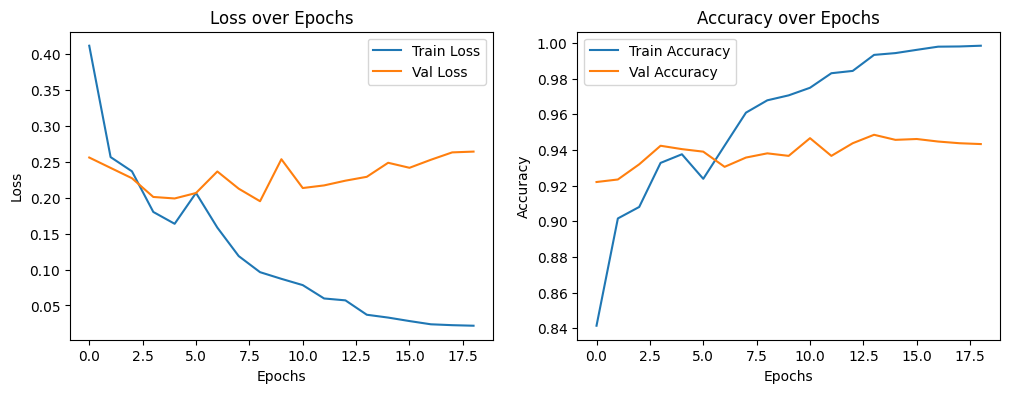

67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.9325 - loss: 0.2155
Test Loss: 0.2155, Test Accuracy: 0.9325


In [116]:
plot_history(history3)
loss, accuracy = model3.evaluate(test_ds)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

En este caso, después de haber descongelado algunas de las últimas capas del modelo preentrenado y haber añadido capas densas nuevas para adaptarlo a nuestro problema específico; se obtuvieron resultados significativamente mejores en comparación con los modelos entrenados desde cero.

Como consecuencia de lo anterior, se define este como el mejor modelo para la tarea en cuestión y se almacena para su posterior evaluación en el conjunto de prueba y uso en aplicaciones futuras.

In [117]:
model3.save("ResNet50V2_COVID19_Classifier.keras")

# Resultados

In [118]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

preds = model3.predict(test_ds)
y_pred = tf.argmax(preds, axis=1).numpy()
y_true = tf.concat([y for _, y in test_ds], axis=0).numpy()

accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

67/67 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step
Test Accuracy: 0.9325


2025-11-11 00:32:00.175646: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


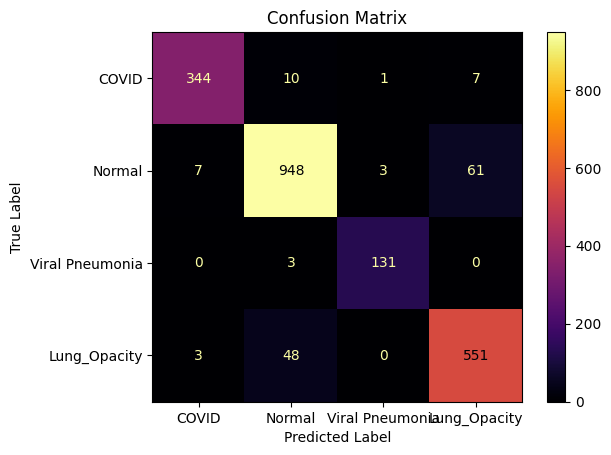

In [119]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clases)
disp.plot(cmap='inferno')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

De la matriz de confusión anterior, se puede observar que el modelo tiene un buen desempeño en la clasificación de imágenes de pacientes sanos y con COVID-19, con pocas confusiones entre estas clases. Sin embargo, hay algunas confusiones notables entre las clases de normal y opacidad pulmonar, lo que indica que el modelo tiene dificultades para distinguir entre estas dos condiciones. Aun así, el modelo presenta un rendimiento sólido en general, incluyendo la clase minoritaria de neumonía, lo que sugiere que la estrategia de manejo del desbalanceo de clases fue efectiva.

In [120]:
report = classification_report(y_true, y_pred, target_names=clases)
print("Classification Report:\n", report)

Classification Report:
                  precision    recall  f1-score   support

          COVID       0.97      0.95      0.96       362
         Normal       0.94      0.93      0.93      1019
Viral Pneumonia       0.97      0.98      0.97       134
   Lung_Opacity       0.89      0.92      0.90       602

       accuracy                           0.93      2117
      macro avg       0.94      0.94      0.94      2117
   weighted avg       0.93      0.93      0.93      2117



# Aplicación para la realización de predicciones

In [122]:

final_model = tf.keras.models.load_model("ResNet50V2_COVID19_Classifier.keras", custom_objects={"preprocess_input": tf.keras.applications.resnet_v2.preprocess_input})

In [123]:
def predict_image(model, img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = tf.expand_dims(img, axis=0)

    predictions = model.predict(img, verbose=0)
    predicted_class = int(tf.argmax(predictions, axis=1).numpy()[0])
    confidence = float(tf.reduce_max(predictions, axis=1).numpy()[0])

    return clases[predicted_class], confidence

In [124]:
# Predecir 5 imagenes de prueba aleatorias de cada clase
import random
for clase in clases:
    ruta_clase = os.path.join(base, clase, "images/")
    imagenes = os.listdir(ruta_clase)
    muestra = random.sample(imagenes, 5)

    print(f"\nPredicciones para la clase '{clase}':")
    for img_name in muestra:
        img_path = os.path.join(ruta_clase, img_name)
        pred_class, conf = predict_image(final_model, img_path)
        print(f"Imagen: {img_name} | Predicción: {pred_class} | Confianza: {conf:.4f}")


Predicciones para la clase 'COVID':
Imagen: COVID-2417.png | Predicción: COVID | Confianza: 1.0000
Imagen: COVID-3074.png | Predicción: COVID | Confianza: 0.9863
Imagen: COVID-2457.png | Predicción: COVID | Confianza: 0.9857
Imagen: COVID-3051.png | Predicción: COVID | Confianza: 0.9999
Imagen: COVID-3264.png | Predicción: COVID | Confianza: 1.0000

Predicciones para la clase 'Normal':
Imagen: Normal-2426.png | Predicción: Normal | Confianza: 0.9915
Imagen: Normal-9859.png | Predicción: Normal | Confianza: 0.9996
Imagen: Normal-7481.png | Predicción: Normal | Confianza: 0.9810
Imagen: Normal-6857.png | Predicción: Normal | Confianza: 0.9623
Imagen: Normal-1970.png | Predicción: Normal | Confianza: 0.9987

Predicciones para la clase 'Viral Pneumonia':
Imagen: Viral Pneumonia-260.png | Predicción: Viral Pneumonia | Confianza: 1.0000
Imagen: Viral Pneumonia-608.png | Predicción: Viral Pneumonia | Confianza: 1.0000
Imagen: Viral Pneumonia-820.png | Predicción: Viral Pneumonia | Confianza:

# Conclusiones

La red neuronal convolucional basada en transfer learning con ResNet50 resultó ser la arquitectura más efectiva para la clasificación de imágenes médicas en este portafolio. Sin embargo, las anteriores arquitecturas implementadas demostraron ser relativamente viables para la tarea en cuestión, esto gracias a la realización de varias iteraciones y el descrubrimiento de la efectividad de ciertas técnicas de regularización como el el manejo del desbalanceo de clases pero sobre todo la reducción de la tasa de aprendizaje durante el entrenamiento.

Aún así, existen áreas de oportunidad para mejorar el rendimiento del modelo, tales como la experimentación con diferentes arquitecturas, la optimización de hiperparámetros, la implementación de técnicas avanzadas de aumento de datos y la incorporación de más datos de entrenamiento. Sin embargo, los resultados obtenidos en este portafolio son prometedores, consiguiendo un modelo que en la parte de la aplicación de este notebook logra predecir con bastante precisión la clase a la que pertenece una imagen médica dada.

# Referencias

* Kermany, D. S., Goldbaum, M., Cai, W., Valentim, C. C. S., Liang, H., Baxter, S. L., McKeown, A., Yang, G., Wu, X., Yan, F., Dong, J., Prasadha, M. K., Pei, J., Ting, M. Y. L., Zhu, J., Li, C., Hewett, S., Dong, J., Ziyar, I., Shi, A., Zhang, R., Zheng, L., Hou, R., Shi, W., Fu, X., Duan, Y., Zhang, E. D., Zhang, C. L., Li, O., Wang, X., Singer, M. A., Sun, X., Xu, J., Tafreshi, A., Lewis, M. A., Xia, H., & Zhang, K. (2018). Identifying medical diagnoses and treatable diseases by image-based deep learning. Cell, 172(5), 1122-1131.e9. https://doi.org/10.1016/j.cell.2018.02.010